<a href="https://colab.research.google.com/github/anikch/Classifying-Reviews-of-Cars-and-Digital-Camera/blob/main/Classifying_Reviews_of_Cars_and_Digital_Camera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epinions.com is a website where people can post reviews of products and services. It covers a wide variety of topics. For this case study, we downloaded a set of 600 posts about digital cameras and cars and saved as “Eopinions.csv”. The dataset has 2 columns: ‘class’ and ‘text’.
We need to predict 'class' based on 'text'.


In [93]:
# Importing required libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_roc_curve, accuracy_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
import warnings
warnings.filterwarnings('ignore')

In [45]:
# Function for Label Encoding
def label_encoding(path):
  df= pd.read_csv(path)
  le= LabelEncoder()
  le.fit(df['class'].unique())
  df['Label']= le.transform(df['class'])
  return df

# Performing Label Encoding
df= label_encoding('/content/Eopinions.csv')
df.head()

,class,text,Label
0,Auto,I have recently purchased a J30T with moderat...,0
1,Camera,I bought this product because I need instant ...,1
2,Auto,I have owned my Buick since 53000 km and I am...,0
3,Camera,This was my first Digital camera so I did qui...,1
4,Camera,Minolta DiMAGE 7Hi is in a digital SLR with 5...,1


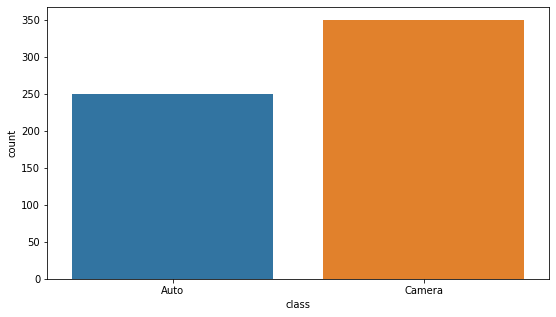

In [46]:
# Plot a bar graph to compare the frequenciesof both the classes.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize= [9,5])
sns.countplot(df['class'])
plt.show()

In [47]:
# Text Pre-processing functions

def Tokenize(text):
    word_tok= word_tokenize(text)
    word_freq= nltk.FreqDist(word_tok)
    #for key, value in word_freq.items():
        #print('Frequency of',key,':',value)
    #print('least occurring tokens:',word_freq.most_common()[-5:])
    return word_tok

def RemoveStopWords(word_tok):
    se= stopwords.words('english')
    word_li=[]
    st_li=[]
    for w in word_tok:
        if w.lower() not in se:
            word_li.append(w)
        else:
            st_li.append(w)
    #print(Counter(st_li))
    return " ".join(word_li)

def Lemmatize(text):
    word_tok= word_tokenize(text.lower())
    lem= WordNetLemmatizer()
    lem_li=[]
    for w in word_tok:
        lem_li.append(lem.lemmatize(w))
    return word_tok, lem_li

def Refine(text):
    tokens= Tokenize(text.lower())
    stop_w_rem= RemoveStopWords(tokens)
    _,lemmas= Lemmatize(stop_w_rem)
    rem_num= [lemma for lemma in lemmas if lemma.isnumeric()== False]
    return (' '.join(rem_num))

In [48]:
# Preprocess the ‘text’ column
df['text_preprocessed']= df.text.apply(lambda x: Refine(x))
df.head(5)

,class,text,Label,text_preprocessed
0,Auto,I have recently purchased a J30T with moderat...,0,recently purchased j30t moderate mile shopped ...
1,Camera,I bought this product because I need instant ...,1,bought product need instant gratification stan...
2,Auto,I have owned my Buick since 53000 km and I am...,0,owned buick since km approaching must say nice...
3,Camera,This was my first Digital camera so I did qui...,1,first digital camera quite bit research unfort...
4,Camera,Minolta DiMAGE 7Hi is in a digital SLR with 5...,1,minolta dimage 7hi digital slr megapixel ccd s...


In [63]:
# Vectorizing using CountVectorizer
cv= CountVectorizer()
X= cv.fit_transform(df.text_preprocessed)
X= pd.DataFrame(X.toarray(), columns= cv.get_feature_names())
X.shape

(600, 11110)

In [65]:
# Getting target
y= df.Label.values
y= Y.reshape(-1,1)
y.shape

(600, 1)

In [66]:
# Train Test split
X_train, X_test, y_train, y_test= train_test_split(X, y, train_size= .8, random_state= 42, stratify= y)

In [72]:
# Performing PCA on training dataset
pca= PCA(.90)
pca= pca.fit(X_train)
X_train_pc= pca.transform(X_train)
X_train_pc.shape

(480, 173)

90% of variance is explained by 173 features. Using PCA, we have reduced the dimension from 11110 to 173.

In [73]:
# Performing PCA on testing dataset
X_test_pc= pca.transform(X_test)

In [78]:
# Implementing XgBoost Classifier

xgb= XGBClassifier(learning_rate= .01, n_jobs= -1, random_state= 42)
xgb.fit(X_train_pc, y_train)
y_train_pred= xgb.predict(X_train_pc)
y_test_pred= xgb.predict(X_test_pc)
print('Training Accuracy:', accuracy_score(y_train, y_train_pred))
print('Testing Accuracy:', accuracy_score(y_test, y_test_pred))

Training Accuracy: 0.9979166666666667
Testing Accuracy: 0.9916666666666667


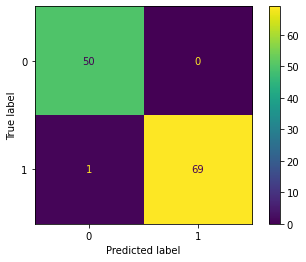

In [98]:
# Plotting Confusion Matrix on teting dataset
plot_confusion_matrix(xgb, X_test_pc, y_test)
plt.show()

In [95]:
# Checking classification report on testing dataset
print('Classification Report on testing data:\n\n', classification_report(y_test, y_test_pred))

Classification Report on testing data:

               precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.99      0.99        70

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



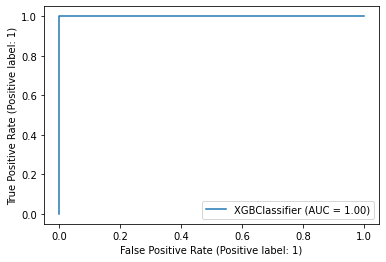

In [92]:
# Plotting ROC on teting dataset
plot_roc_curve(xgb, X_test_pc, y_test)
plt.show()

AUC = 1 on tetsing dataset. We have got very good accuracy and other metrics on training and testing dataset.